In [1]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

import numpy as np
from tqdm.notebook import tqdm
import torch

# import minimax scaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
from response.maps import  collect_posterior_means
from deep_traffic_generation.cvae import CVAE
from deep_traffic_generation.core.datasets import TSDataset
from traffic.core import Traffic

# add automatic reloading of modules
%load_ext autoreload
%autoreload 2

device = "cpu"

# seed everything
np.random.seed(32)
torch.manual_seed(32)
torch.cuda.manual_seed(32)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Loading data and model

In [2]:
import pandas as pd

data_path = "data/eog/EOG.parquet"
df = pd.read_parquet(data_path)

# Convert each row in 'dim_0' to a NumPy array, then stack them into a 2D array
X = np.stack(df['dim_0'].to_numpy())

# X current shape is (n_samples, n_timesteps)
# We need to add a channel dimension to make it (n_samples, 1, n_timesteps)
X = np.expand_dims(X, axis=1)

y = df['target'].values

dataset = TSDataset(X, y)

In [4]:
# Over trained network
path_tcvae = r"models\eog.ckpt"
model = CVAE.load_from_checkpoint(path_tcvae, dataset_params=dataset.parameters).to(device)

RuntimeError: Attempting to deserialize object on CUDA device 3 but torch.cuda.device_count() is 1. Please use torch.load with map_location to map your storages to an existing device.

Collect posterior means

In [ ]:
# Collect posterior samples for the histogram
batch_size = 512
Z = collect_posterior_means(model, dataset, device=device, batch_size=batch_size, pbar=tqdm).detach().cpu()

  0%|          | 0/990 [00:00<?, ?it/s]

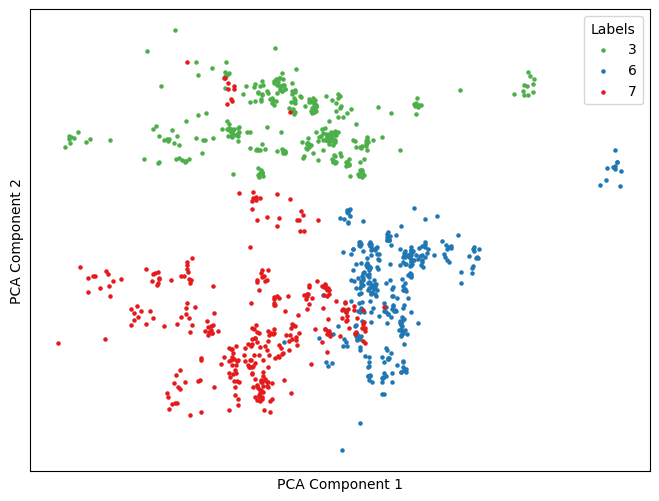

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Assuming 'Z' is already available in the environment
# Loading the labels
labels = dataset.labels

# Check if labels length matches the number of data points in Z
if len(labels) != Z.shape[0]:
    # If labels are more than the data points, we subset the labels to match the data
    labels = labels[:Z.shape[0]]

plt.rcParams.update({
    "text.usetex": False,  # Set to True if using LaTeX
    "font.family": "serif",
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

# Performing PCA
Z_pca = PCA(n_components=2).fit_transform(Z)

# Define a consistent color mapping for labels
color_map = {
      '3': '#4daf4a',
        '6': '#1f77b4',
        '7': '#e41a1c',
}

# Plotting
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)
for label in unique_labels:
    idx = np.where(labels == label)
    color = color_map.get(label, '#000000')  # Default to black if label not in color_map
    plt.scatter(Z_pca[idx, 0], Z_pca[idx, 1], label=label, color=color, alpha=1, s=5)

# plt.title("PCA plot of Z data with 2 components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Remove grid and axis numbers
plt.grid(False)  # Remove the grid
plt.gca().set_xticks([])  # Remove x-axis numbers
plt.gca().set_yticks([])  # Remove y-axis numbers

plt.legend(title="Labels")
plt.show()

plt.savefig('figures/eog/pca.pdf')
